# Проект исследования стартапов

Цель проекта:

- Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. 
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

План работ:

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

Датасет состоит из двух файлов: тренировочный и тестовый.

Описание полей данных:

- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

In [1]:
!pip install matplotlib
!pip install scikit-learn --upgrade
!pip install shap
!pip install phik

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import phik

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score


import shap

## Загрузка и ознакомление с данными

In [316]:
train = pd.read_csv("/Users/ADMINX/Project startup/kaggle_startups_train_28062024.csv")

In [317]:
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [318]:
train.shape

(52516, 13)

In [319]:
test = pd.read_csv("/Users/ADMINX/Project startup/kaggle_startups_test_28062024.csv")

In [320]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [321]:
test.shape

(13125, 11)

In [322]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [323]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


Файлы загружены, данные соответствуют описанию данных.

## Предобработка данных

Проверим наличие пропусков в файлах.

In [324]:
train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [325]:
test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

Пропусков довольно много в обоих файлах. 

Проверим наличие явных дубликатов.

In [326]:
train.duplicated().sum()

0

In [327]:
test.duplicated().sum()

0

Проверим наличие неявных дубликатов.

In [328]:
cat_col = ['category_list', 'country_code', 'state_code', 'region', 'city']

In [329]:
for i in cat_col:
    print(f'Уникальные значения {i}: {train[i].unique()}')

Уникальные значения category_list: ['Online Reservations|Restaurants' 'Manufacturing|Medical|Medical Devices'
 'Biotechnology' ... 'Gambling|Games|Online Gaming|Sports'
 'Aerospace|Mobile|Transportation|Travel'
 'Online Rental|Parking|Price Comparison']
Уникальные значения country_code: ['CHE' 'USA' nan 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS' 'TWN'
 'CHN' 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD' 'ARG'
 'ARE' 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA' 'GRC'
 'ROM' 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA' 'JOR'
 'AUT' 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX' 'SVN'
 'POL' 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA' 'TTO'
 'UKR' 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT' 'PSE'
 'BLZ' 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM' 'PRY' 'BMU'
 'TAN' 'LIE' 'GRD' 'UZB' 'GEO' 'SEN' 'ALB' 'ECU' 'MOZ' 'LKA' 'LAO' 'TUN'
 'HND' 'ZWE' 'BAH' 'MDA' 'MAF' 'BHR' 'AZE' 'MAR' 'KWT' 'I

In [330]:
for i in cat_col:
    print(f'Кол-во уникальных значений {i}: {train[i].nunique()}')

Кол-во уникальных значений category_list: 22105
Кол-во уникальных значений country_code: 134
Кол-во уникальных значений state_code: 300
Кол-во уникальных значений region: 1036
Кол-во уникальных значений city: 4477


Уникальных значений также много, логично предположить, что state_code для США обозначает код штата или провинции, а для других стран код города/региона.\
Поделим train на две части: стартапы США и стартапы остальных стран.

In [331]:
train_USA = train.loc[train['country_code'] == 'USA']
train_not_USA = train.loc[train['country_code'] != 'USA']

In [332]:
for i in cat_col:
    print(f'Кол-во уникальных значений {i}: {train_USA[i].nunique()}')

Кол-во уникальных значений category_list: 12492
Кол-во уникальных значений country_code: 1
Кол-во уникальных значений state_code: 53
Кол-во уникальных значений region: 242
Кол-во уникальных значений city: 2345


In [333]:
train_USA.isna().sum()

name                     1
category_list          733
funding_total_usd     4847
status                   0
country_code             0
state_code              35
region                  89
city                    89
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            27418
dtype: int64

In [334]:
train_USA.loc[train_USA['region'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
105,Amp'd Mobile,Mobile,374000000.0,closed,USA,NaN,NaN,NaN,4,2003-09-24,2005-08-08,2007-03-21,2009-02-16
874,Escoublac,Biotechnology,6650000.0,closed,USA,MA,NaN,NaN,1,2007-07-05,2008-01-09,2008-01-09,2009-02-22
933,TSCA,Finance,1080000.0,operating,USA,CA,NaN,NaN,1,2014-07-12,2014-08-29,2014-08-29,NaN
1244,Link Egglepple Starbureiy,Finance|Leisure,2000000.0,operating,USA,MT,NaN,NaN,2,1997-02-28,2015-01-15,2015-11-02,NaN
1524,Haven Hill Homestead,Consumer Goods|Handmade|Lifestyle,NaN,operating,USA,NaN,NaN,NaN,1,2007-08-06,2014-01-26,2014-01-26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48537,HashCube,Games|Internet|Social Games,684150.0,operating,USA,IN,NaN,NaN,2,2008-01-01,2012-05-01,2014-11-06,NaN
49685,RetailVector,Curated Web,NaN,operating,USA,IN,NaN,NaN,1,2009-01-01,2009-08-13,2009-08-13,NaN
50848,MotorExchange,Automotive,NaN,operating,USA,IN,NaN,NaN,1,2008-05-22,2009-12-18,2009-12-18,NaN
50861,3DLT,3D Printing|Retail|Technology,530000.0,operating,USA,KY,NaN,NaN,1,2012-12-01,2014-08-22,2014-08-22,NaN


Для 89 стартапов США неизвестны регион и город, в 35 случаях и штат. Заполним их значением unknown.

In [335]:
# пайплайн для заполнения пропусков на unknown

simple_imputer_unknown = Pipeline(
    [
        (
            'SimpleImputer', 
            SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')
        )
    ]
)

In [336]:
# заполнение пропусков с помощью пайплайна

cols_train_address = ['state_code', 'region', 'city']

train_USA[cols_train_address] = simple_imputer_unknown.fit_transform(train_USA[cols_train_address])

C:\Users\ADMINX\AppData\Local\Temp\ipykernel_13828\438931750.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_USA[cols_train_address] = simple_imputer_unknown.fit_transform(train_USA[cols_train_address])


In [337]:
train_USA.isna().sum()

name                     1
category_list          733
funding_total_usd     4847
status                   0
country_code             0
state_code               0
region                   0
city                     0
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            27418
dtype: int64

In [338]:
train_USA['closed_at'].loc[train_USA['status'] == 'operating'].unique()

array([nan], dtype=object)

Стартапы с NaN значениями даты закрытия стратапа (closed_at) в статусе "действующий", поэтому просто заменим пропуски на 0.

In [339]:
train_USA['closed_at'] = train_USA['closed_at'].fillna(0)

C:\Users\ADMINX\AppData\Local\Temp\ipykernel_13828\3110986530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_USA['closed_at'] = train_USA['closed_at'].fillna(0)


In [340]:
train_USA.isna().sum()

name                    1
category_list         733
funding_total_usd    4847
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
closed_at               0
dtype: int64

In [341]:
#замена пропуска в названии стратапа на unknown

train_USA['name'] = train_USA['name'].fillna('unknown')

C:\Users\ADMINX\AppData\Local\Temp\ipykernel_13828\1359274635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_USA['name'] = train_USA['name'].fillna('unknown')


Пропуски в категории заменим на самое часто встречающееся значение.

In [342]:
# пайплайн для заполнения пропусков на моду

simple_imputer_moda = Pipeline(
    [
        (
            'SimpleImputer', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [343]:
# заполнение пропусков с помощью пайплайна

category = ['category_list']

train_USA[category] = simple_imputer_moda.fit_transform(train_USA[category])

C:\Users\ADMINX\AppData\Local\Temp\ipykernel_13828\1364655256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_USA[category] = simple_imputer_moda.fit_transform(train_USA[category])


In [344]:
train_USA.isna().sum()

name                    0
category_list           0
funding_total_usd    4847
status                  0
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
closed_at               0
dtype: int64

In [216]:
for i in cat_col:
    print(f'Уникальные значения {i}: {train_USA[i].unique()}')

Уникальные значения category_list: ['Manufacturing|Medical|Medical Devices' 'Biotechnology' 'Manufacturing'
 ... 'Field Support Services|Mobile|Tech Field Support'
 'Aerospace|Mobile|Transportation|Travel'
 'Email|Messaging|Productivity Software']
Уникальные значения country_code: ['USA']
Уникальные значения state_code: ['CA' 'VA' 'NJ' 'TX' 'OR' 'FL' 'WA' 'NY' 'AZ' 'GA' 'MA' 'PA' 'MI' 'MN'
 'DE' 'RI' 'CO' 'IL' 'OH' 'AL' 'NC' 'MD' 'unknown' 'ND' 'VT' 'UT' 'IN'
 'CT' 'NV' 'IA' 'WI' 'NM' 'MO' 'ME' 'NH' 'SC' 'TN' 'LA' 'KS' 'AR' 'NE'
 'DC' 'ID' 'MT' 'KY' 'MS' 'HI' 'AK' 'WY' 'OK' 'SD' 'WV' 'VI' 'GU']
Уникальные значения region: ['SF Bay Area' 'VA - Other' 'Newark' 'Houston' 'Austin' 'Portland, Oregon'
 'Tampa' 'Seattle' 'New York City' 'Phoenix' 'Atlanta' 'Los Angeles'
 'Boston' 'Philadelphia' 'Detroit' 'Minneapolis' 'Dover' 'Providence'
 'Denver' 'Ft. Lauderdale' 'Chicago' 'Akron - Canton' 'Dallas'
 'Washington, D.C.' 'Ontario - Inland Empire' 'Huntsville' 'Charlotte'
 'Baltimore' 'unknown'

In [366]:
train_USA['funding_total_usd'].describe()

count    2.485500e+04
mean     2.054454e+07
std      2.152760e+08
min      1.000000e+00
25%      5.016275e+05
50%      3.000000e+06
75%      1.350000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

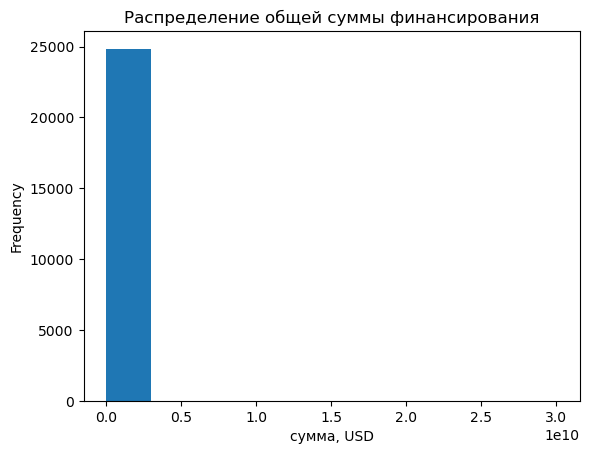

In [346]:
train_USA['funding_total_usd'].plot(kind='hist')
plt.title('Распределение общей суммы финансирования')
plt.xlabel('сумма, USD')
plt.show()

Есть выбросы посмотрим на стратапы, получиdшие сумму выше средней.

In [370]:
train_USA.query('funding_total_usd > 2.054454e+07')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,0
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,0
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,0
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,0
17,Avi Networks Inc,Analytics|Cloud Data Services|Computers|Networ...,33000000.0,operating,USA,CA,SF Bay Area,Sunnyvale,2,2012-01-01,2012-11-01,2014-08-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52408,Metabolon,Biotechnology|Health Diagnostics,56420551.0,operating,USA,NC,Raleigh,Durham,7,2000-01-01,2003-08-01,2015-03-09,0
52409,HydroPoint Data Systems,Agriculture|Analytics|Water,40094161.0,operating,USA,CA,Napa Valley,Petaluma,4,2002-01-01,2004-11-11,2012-12-14,0
52430,Baker Oil & Gas,Energy Management|Natural Resources|Oil & Gas,39000000.0,operating,USA,TX,Houston,Houston,1,2013-08-02,2014-03-18,2014-03-18,0
52443,Northwest Biotherapeutics,Biotechnology,113895000.0,operating,USA,MD,"Washington, D.C.",Bethesda,5,1998-01-01,2010-12-09,2015-04-03,0


In [372]:
train_USA.query('funding_total_usd < 2.054454e+07')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,0
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,0
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,0
11,Seven Seas Water,Clean Technology,20000000.0,operating,USA,FL,Tampa,Tampa,1,1997-01-01,2008-02-04,2008-02-04,0
13,BuildersCloud,Software,1100000.0,operating,USA,WA,Seattle,Bellevue,1,2012-01-01,2013-08-08,2013-08-08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52505,IdleAir,Clean Technology,3000000.0,operating,USA,TN,Knoxville,Knoxville,1,2010-04-13,2011-06-23,2011-06-23,0
52506,Dignify Therapeutics,Biotechnology,3209000.0,operating,USA,NC,Raleigh,Raleigh,3,2013-01-01,2014-02-05,2015-02-04,0
52509,Visionary Mobile,Biotechnology,1570000.0,operating,USA,OR,"Salem, Oregon",Corvallis,3,2010-01-01,2011-09-20,2012-04-11,0
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,0


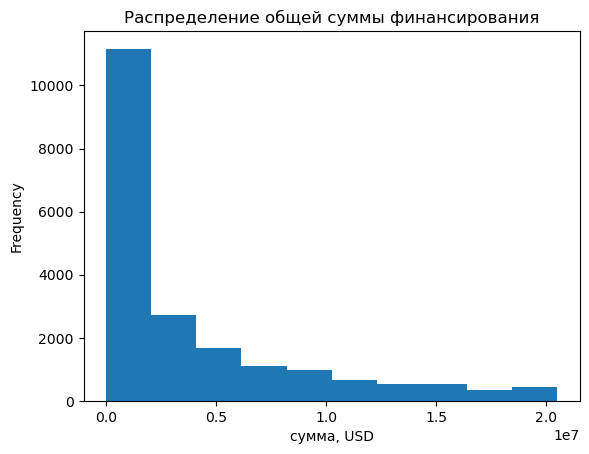

In [373]:
train_USA.query('funding_total_usd < 2.054454e+07')['funding_total_usd'].plot(kind='hist')
plt.title('Распределение общей суммы финансирования')
plt.xlabel('сумма, USD')
plt.show()

In [354]:
train_USA.query('funding_total_usd <= 5000000000')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,0
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,0
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,0
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,0
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52505,IdleAir,Clean Technology,3000000.0,operating,USA,TN,Knoxville,Knoxville,1,2010-04-13,2011-06-23,2011-06-23,0
52506,Dignify Therapeutics,Biotechnology,3209000.0,operating,USA,NC,Raleigh,Raleigh,3,2013-01-01,2014-02-05,2015-02-04,0
52509,Visionary Mobile,Biotechnology,1570000.0,operating,USA,OR,"Salem, Oregon",Corvallis,3,2010-01-01,2011-09-20,2012-04-11,0
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,0


Всего 4 стартапа получили финсирование существенно выше других стратапов.

In [43]:
for i in cat_col:
    print(f'Уникальные значения {i}: {train_not_USA[i].unique()}')

Уникальные значения category_list: ['Online Reservations|Restaurants' 'Health Care' nan ...
 'Bio-Pharm|Health and Wellness|Health Care|Life Sciences|Manufacturing|Pharmaceuticals'
 'Gambling|Games|Online Gaming|Sports'
 'Online Rental|Parking|Price Comparison']
Уникальные значения country_code: ['CHE' nan 'GBR' 'RUS' 'ESP' 'FRA' 'SWE' 'IND' 'KOR' 'AUS' 'TWN' 'CHN'
 'HUN' 'CAN' 'FIN' 'BRA' 'EGY' 'PRT' 'ISR' 'CHL' 'SVK' 'NLD' 'ARG' 'ARE'
 'JPN' 'IRL' 'DEU' 'LBN' 'EST' 'IDN' 'BEL' 'MEX' 'DNK' 'ITA' 'GRC' 'ROM'
 'TUR' 'SGP' 'SAU' 'MYS' 'NGA' 'QAT' 'VNM' 'BGR' 'GHA' 'UGA' 'JOR' 'AUT'
 'PAK' 'NZL' 'HKG' 'ZAF' 'LVA' 'NOR' 'HRV' 'VEN' 'PER' 'LUX' 'SVN' 'POL'
 'PHL' 'NIC' 'CZE' 'ISL' 'PAN' 'URY' 'BGD' 'MCO' 'GTM' 'THA' 'TTO' 'UKR'
 'KEN' 'CRI' 'DZA' 'LTU' 'CYM' 'MUS' 'BLR' 'SLV' 'COL' 'MLT' 'PSE' 'BLZ'
 'CYP' 'MMR' 'MKD' 'KHM' 'GIB' 'SRB' 'DOM' 'BWA' 'BLM' 'PRY' 'BMU' 'TAN'
 'LIE' 'GRD' 'UZB' 'GEO' 'SEN' 'ALB' 'ECU' 'MOZ' 'LKA' 'LAO' 'TUN' 'HND'
 'ZWE' 'BAH' 'MDA' 'MAF' 'BHR' 'AZE' 'MAR' 'KWT'